# AIM: develop the pretext task with EEGNet
Trained with demeaned epochs

In [1]:
import numpy as np
import pandas as pd
import mne
import lightning.pytorch as pl
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchmetrics import F1Score, Accuracy
import random
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
import itertools
from torch.utils.data import Dataset, DataLoader, Subset
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
%matplotlib inline

# prevent extensive logging
mne.set_log_level('WARNING')

## Pretext model & components:

### EEGNet:

In [2]:
# create Conv2d with max norm constraint
class Conv2dWithConstraint(nn.Conv2d):
    def __init__(self, *args, max_norm: int = 1, **kwargs):
        self.max_norm = max_norm
        super(Conv2dWithConstraint, self).__init__(*args, **kwargs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        self.weight.data = torch.renorm(self.weight.data, p=2, dim=0, maxnorm=self.max_norm)
        return super(Conv2dWithConstraint, self).forward(x)
    
class EEGNet(nn.Module):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self,
                 chunk_size: int = 1244, # number of data points in each EEG chunk
                 num_electrodes: int = 26, # number of EEG electrodes
                 F1: int = 8, # number of filters in first convolutional layer
                 F2: int = 16, # number of filters in second convolutional layer
                 D: int = 2, # depth multiplier
                 num_extracted_features: int = 100, # number of features to extract  ## QUESTION
                 kernel_1: int = 64, # the filter size of block 1 (half of sfreq (125 Hz)) ## QUESTION 
                 kernel_2: int = 16, # the filter size of block 2 (one eight of sfreq (500 Hz)) ## QUESTION
                 dropout: float = 0.25): # dropout rate
        super(EEGNet, self).__init__()
        self.F1 = F1
        self.F2 = F2
        self.D = D
        self.chunk_size = chunk_size
        self.num_extracted_features = num_extracted_features
        self.num_electrodes = num_electrodes
        self.kernel_1 = kernel_1
        self.kernel_2 = kernel_2
        self.dropout = dropout

        self.block1 = nn.Sequential(
            nn.Conv2d(1, self.F1, (1, self.kernel_1), stride=1, padding=(0, self.kernel_1 // 2), bias=False),
            nn.BatchNorm2d(self.F1, momentum=0.01, affine=True, eps=1e-3),
            Conv2dWithConstraint(self.F1,
                                 self.F1 * self.D, (self.num_electrodes, 1),
                                 max_norm=1,
                                 stride=1,
                                 padding=(0, 0),
                                 groups=self.F1,
                                 bias=False), nn.BatchNorm2d(self.F1 * self.D, momentum=0.01, affine=True, eps=1e-3),
            nn.ELU(), nn.AvgPool2d((1, 4), stride=4), nn.Dropout(p=dropout))

        self.block2 = nn.Sequential(
            nn.Conv2d(self.F1 * self.D,
                      self.F1 * self.D, (1, self.kernel_2),
                      stride=1,
                      padding=(0, self.kernel_2 // 2),
                      bias=False,
                      groups=self.F1 * self.D),
            nn.Conv2d(self.F1 * self.D, self.F2, 1, padding=(0, 0), groups=1, bias=False, stride=1),
            nn.BatchNorm2d(self.F2, momentum=0.01, affine=True, eps=1e-3), nn.ELU(), nn.AvgPool2d((1, 8), stride=8),
            nn.Dropout(p=dropout))

        self.lin = nn.Linear(self.feature_dim(), num_extracted_features, bias=False)


    def feature_dim(self):
        # function to calculate the number of features after the convolutional blocks
        with torch.no_grad():
            mock_eeg = torch.zeros(1, 1, self.num_electrodes, self.chunk_size)

            mock_eeg = self.block1(mock_eeg)
            mock_eeg = self.block2(mock_eeg)

        return self.F2 * mock_eeg.shape[3]

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.block1(x)
        x = self.block2(x)
        x = x.flatten(start_dim=1)
        x = self.lin(x)
        return x

### pretext model:

In [3]:
class PretextModel(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self, num_extracted_features=100, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
        super(PretextModel, self).__init__()
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        # feature extractors
        self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
        
        # linear discriminate layer
        self.linear = nn.Linear(num_extracted_features, 1)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
        x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
        x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
        z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
        x = self.linear(z) # forward pass through linear layer
        return x
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y = train_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y = val_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch[0]
        y = test_batch[1]
        y = y.float()
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.binary_cross_entropy_with_logits(logits, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x = batch[0]
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
        return optimizer
    


## Pretext task

#### Functions & Classes

In [4]:
def get_participant_ids(eeg_dir, epoch_dir=False):
    """
    Function to get all participant ids from EEG data directory
    :param eeg_dir: directory where EEG data is stored
    :param epoch_dir: whether the data that we want to retrieve is from the epoch directory or from the raw EEG data directory
    :return: list of participant ids
    """
    participant_ids = []
    if epoch_dir == False:
        for subdir, dirs, files in os.walk(eeg_dir): # iterate through all files
            for file in files:
                if 'ses-1' in file and '.npy' in file and 'BAD' not in file: # filter first session, .npy files, and non-bad files
                    participant_id = file.split('_')[0] # extract participant id
                    if participant_id not in participant_ids:
                        participant_ids.append(participant_id)
    else:
        participant_ids = [file.split('.')[0] for file in os.listdir(eeg_dir) if '.pt' in file]
        
    return participant_ids


def train_pretext_model(pretext_task, max_epochs, data_train, data_val, batch_size, learning_rate=0.001, dropout=0.25, weight_decay=0, store_weights=(True, True)):
    """
    Function to train the pretext model
    :param pretext_task: title (string) describing the pretext task for saving the model weights
    :param max_epochs: maximum number of epochs to train the model
    :param data_train: training data
    :param data_val: validation data
    :param batch_size: batch size
    :param learning_rate: learning rate
    :param dropout: dropout rate
    :param weight_decay: weight decay
    :param store_weights: whether to store the weights of the overtrained model and the best checkpoint model
    :return: trained model loaded with best checkpoint
    """
    # remove particular warnings
    warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")
    warnings.filterwarnings("ignore", ".*Trying to infer the `batch_size` from an ambiguous collection*")

    logger = CSVLogger("logs", name="across_RP_pretext_task") # log results to csv file
    torch.set_float32_matmul_precision('high') # for use of tensor cores
    # create pretext model
    model = PretextModel(learning_rate=learning_rate, dropout=dropout, weight_decay=weight_decay)
    
    # create data loaders
    train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(data_val, batch_size=batch_size, shuffle=False)
    
    checkpoint_callback = ModelCheckpoint(monitor='val_f1',
                                    mode='max',
                                    save_top_k=3,
                                    filename='{epoch}-{train_loss:.2f}-{train_f1:.2f}-{val_loss:.2f}-{val_f1:.2f}',
                                    )

    trainer = Trainer(
        precision='16-mixed',
        accelerator='gpu',
        devices=1,
        max_epochs=max_epochs,
        callbacks=checkpoint_callback,
        enable_progress_bar=True,
        enable_model_summary=True,
        enable_checkpointing=True,
        logger=logger,
        log_every_n_steps=5,
    )

    trainer.fit(model, train_loader, val_loader)

    if store_weights[0]:
        torch.save(model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/overtrained_{pretext_task}_weights.pt')
    
    # load best model checkpoint
    best_model = PretextModel.load_from_checkpoint(checkpoint_callback.best_model_path)
    print(f"Best model checkpoint path: {checkpoint_callback.best_model_path}")
    if store_weights[1]:
        torch.save(best_model.state_dict(), f'D:/Documents/Master_Data_Science/Thesis/thesis_code/DataScience_Thesis/data/pretext_model_weights/{pretext_task}_weights.pt')

    return best_model

def plot_training_curves(metrics_path):
    """
    Function to plot training curves from csv log file
    :param metrics_path: path to the csv file containing the model diagnostics
    :return:
    """
    metrics = pd.read_csv(metrics_path)
    train_f1_epoch = metrics['train_f1_epoch'].dropna()
    train_loss_epoch = metrics['train_loss_epoch'].dropna()
    val_f1 = metrics['val_f1'].dropna()
    val_loss = metrics['val_loss'].dropna()
    
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # plot training and validation F1-score
    axs[0].plot(train_f1_epoch, label='train_f1_score')
    axs[0].plot(val_f1, label='val_f1_score')
    axs[0].set_xlabel('Steps')
    axs[0].set_ylabel('F1-score')
    axs[0].legend()
    axs[0].set_title('Training and validation F1-score')

    # plot training and validation loss
    axs[1].plot(train_loss_epoch, label='train_loss')
    axs[1].plot(val_loss, label='val_loss')
    axs[1].set_xlabel('Steps')
    axs[1].set_ylabel('Loss')
    axs[1].legend()
    axs[1].set_title('Training and validation loss')


    plt.tight_layout()
    plt.show()

    return

def evaluate_pretext_model(model, data_test, test_labels, batch_size=None):
    """
    Function to evaluate the pretext model
    :param model: trained model
    :param data_test: test data
    :param test_labels: test labels
    :param batch_size: batch size
    :return: test results
    """
    if batch_size is None:
        batch_size = len(data_test)
        
    # obtain predictions on test set and plot confusion matrix
    test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=False,
                                drop_last=True)

    # model = PretextModel.load_from_checkpoint(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\pretext_task\version_15\checkpoints\epoch=45-train_loss=54.10-train_f1=0.67-val_loss=106.12-val_f1=0.72.ckpt')

    trainer = Trainer(accelerator='gpu', devices=1, enable_progress_bar=False, enable_model_summary=False, logger=False, enable_checkpointing=False)
    trainer.test(model, test_loader)

    # compute confusion matrix and classification report with sklearn of best model checkpoint
    from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
    y_pred = trainer.predict(model, test_loader)
    y_pred = np.concatenate(y_pred).flatten()
    y = test_labels

    class_labels = ['separated', 'adjacent']
    print('classification report:\n', classification_report(y, y_pred, target_names=class_labels))
    print('F1-score:\n', f1_score(y, y_pred, average="macro"))
    print('Accuracy:\n', (y == y_pred).sum() / len(y))
    cm = confusion_matrix(y, y_pred)
    ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels).plot(cmap = 'Blues', values_format = 'd', colorbar=False)
    plt.grid(False)

    return

In [5]:
class Across_Subject_RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu', n_samples=2):
        """
        Dataset for the Relative Positioning task. Obtains n combinations of two epochs between all groups of two participants.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_across_subject_combinations(self.data_cache, n=self.n_samples)
    
    def sample_across_subject_combinations(self, data_cache, n):
        all_participant_combinations = list(itertools.combinations(self.participant_ids, 2)) # all combinations of participants
        warning_displayed = False  # Flag to track if the warning has been displayed

        for participant_id_1, participant_id_2 in all_participant_combinations: 
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            num_epochs_1 = data_1.shape[0]
            num_epochs_2 = data_2.shape[0]
            # Get all combinations of indices between data_1 and data_2
            all_combinations = list(itertools.product(range(num_epochs_1), range(num_epochs_2)))
            
            # Filter combinations based on the difference between indices
            adjacent_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) <= self.tpos and comb[0] != comb[1]]
            separate_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) > self.tpos]
            # Sample n combinations from each filtered set
            sampled_adjacent_combinations = random.sample(adjacent_combinations,
                                                        min(n, len(adjacent_combinations)))
            sampled_separate_combinations = random.sample(separate_combinations,
                                                     min(n, len(separate_combinations)))
            
            if n > len(adjacent_combinations) and not warning_displayed:
                print(f"Warning: asking for {n} adjacent samples, but only {len(adjacent_combinations)} adjacent samples available between two participants.")
                print("This will result in class imbalance.")
                warning_displayed = True  # Set the flag to True after displaying the warning

            # Store the combinations and labels
            for i, j in sampled_adjacent_combinations:
                self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, 1))
                self.labels.append(1)
            for i, j in sampled_separate_combinations:
                self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, 0))
                self.labels.append(0)

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        data_1 = self.data_cache[participant_id_1]
        data_2 = self.data_cache[participant_id_2]
        epoch_1 = data_1[i]
        epoch_2 = data_2[j]
        sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Data loading & splitting

In [6]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

(array([0, 1]), array([646953, 646953], dtype=int64))
1293906
torch.Size([2, 26, 1244])


In [7]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)

In [8]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')

# Create subsets using the indices
data_train = Subset(train_dataset, data_train_indices)
data_val = Subset(train_dataset, data_val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in data_train_indices]
val_labels = [train_dataset.labels[i] for i in data_val_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([0, 1]), array([517562, 517562], dtype=int64))
Val: (array([0, 1]), array([129391, 129391], dtype=int64))
Test: (array([0, 1]), array([5565, 5565], dtype=int64))


#### Training pretext model

In [ ]:
# train pretext model with default parameters
model = train_pretext_model(
    pretext_task='acrossRP_default_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

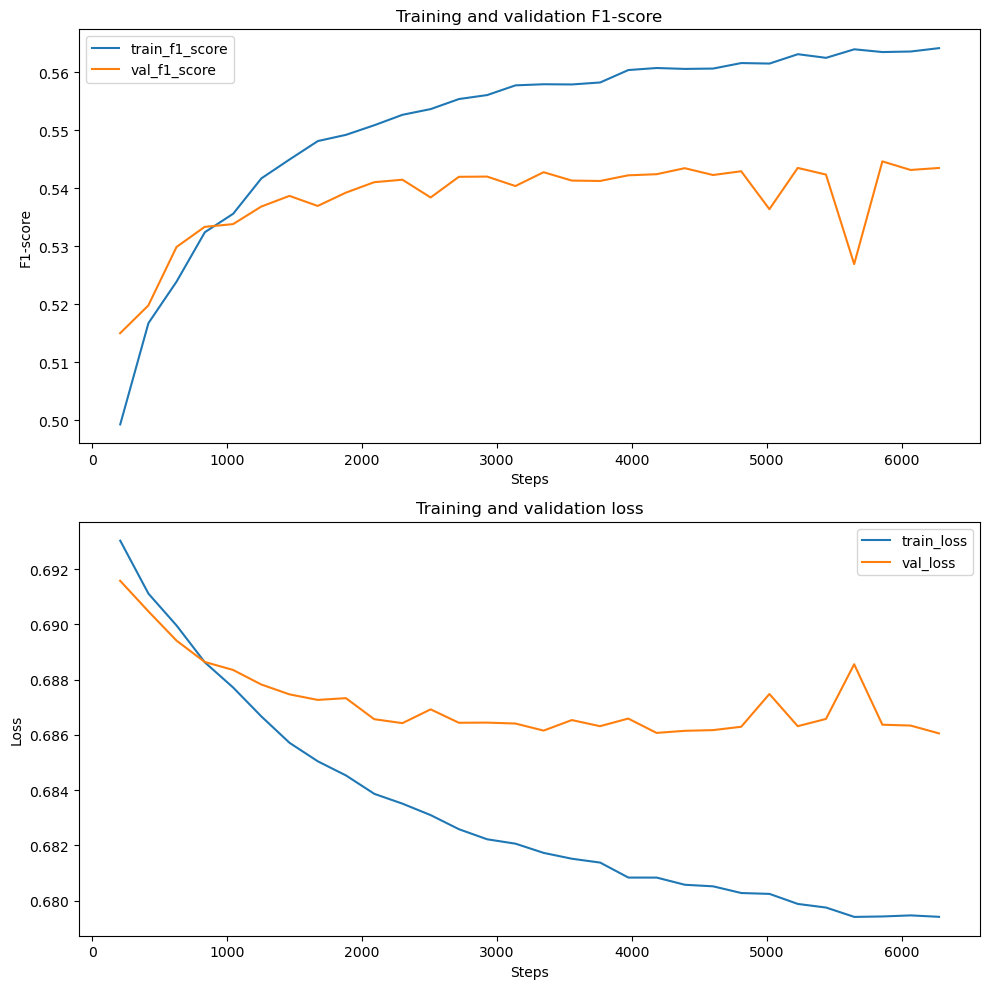

In [11]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_RP_pretext_task\version_0\metrics.csv')

In [ ]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels)

## Pretext model with weight decay and 0.5 dropout

unable to learn

In [9]:
model = train_pretext_model(
    pretext_task='acrossRP_0.5dropout_0.01wd_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=1e-5,
    dropout=0.5,
    weight_decay=0.01,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\lightning\pytorch\trainer\call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


Best model checkpoint path: logs\across_RP_pretext_task\version_1\checkpoints\epoch=0-train_loss=0.69-train_f1=0.37-val_loss=0.69-val_f1=0.33.ckpt


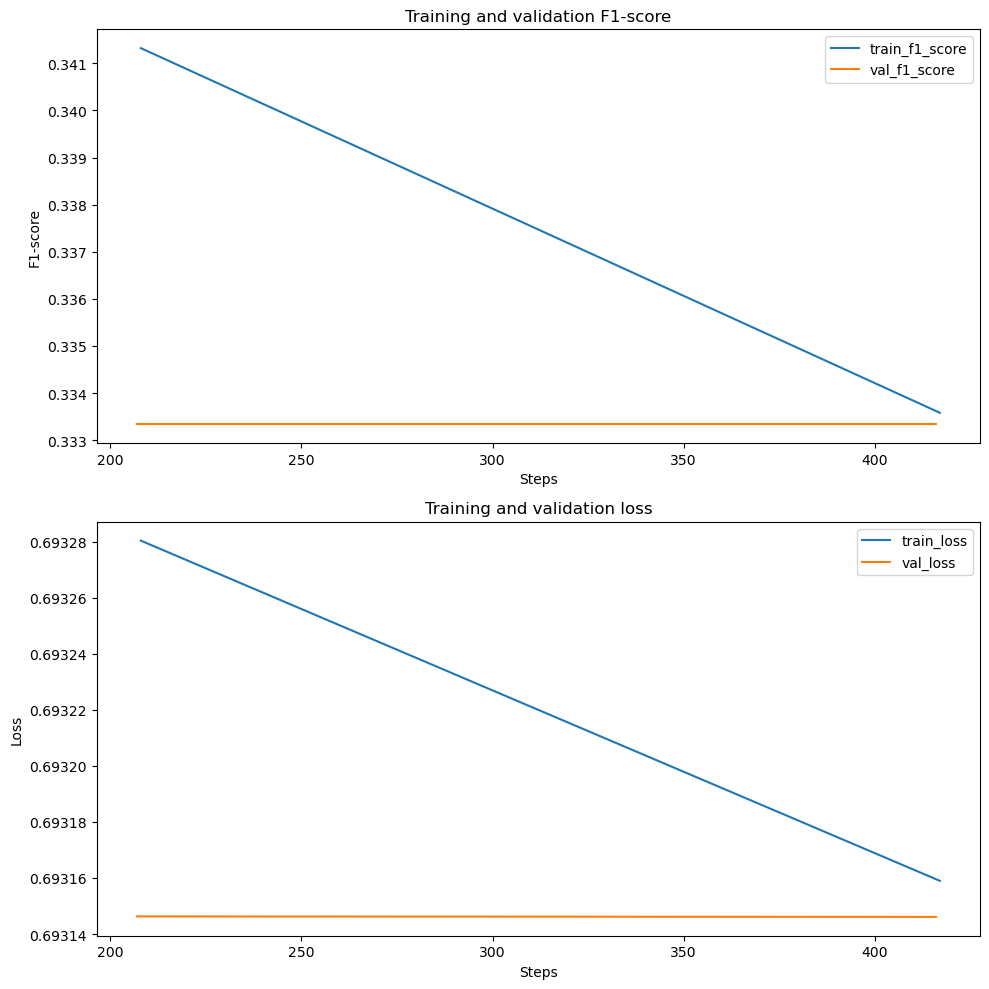

In [12]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_RP_pretext_task\version_1\metrics.csv')

In [ ]:
evaluate_pretext_model(model, test_dataset, test_dataset.labels, batch_size=1000)

## Pretext model with higher tpos

In [6]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=2, n_samples=1)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=2, n_samples=1)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

(array([0, 1]), array([646953, 646953], dtype=int64))
1293906
torch.Size([2, 26, 1244])


In [7]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)

In [8]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')

# Create subsets using the indices
data_train = Subset(train_dataset, data_train_indices)
data_val = Subset(train_dataset, data_val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in data_train_indices]
val_labels = [train_dataset.labels[i] for i in data_val_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([0, 1]), array([517562, 517562], dtype=int64))
Val: (array([0, 1]), array([129391, 129391], dtype=int64))
Test: (array([0, 1]), array([5565, 5565], dtype=int64))


#### Training pretext model

In [9]:
model = train_pretext_model(
    pretext_task='acrossRP_tpos2_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_RP_pretext_task\version_2\checkpoints\epoch=24-train_loss=0.68-train_f1=0.58-val_loss=0.68-val_f1=0.57.ckpt


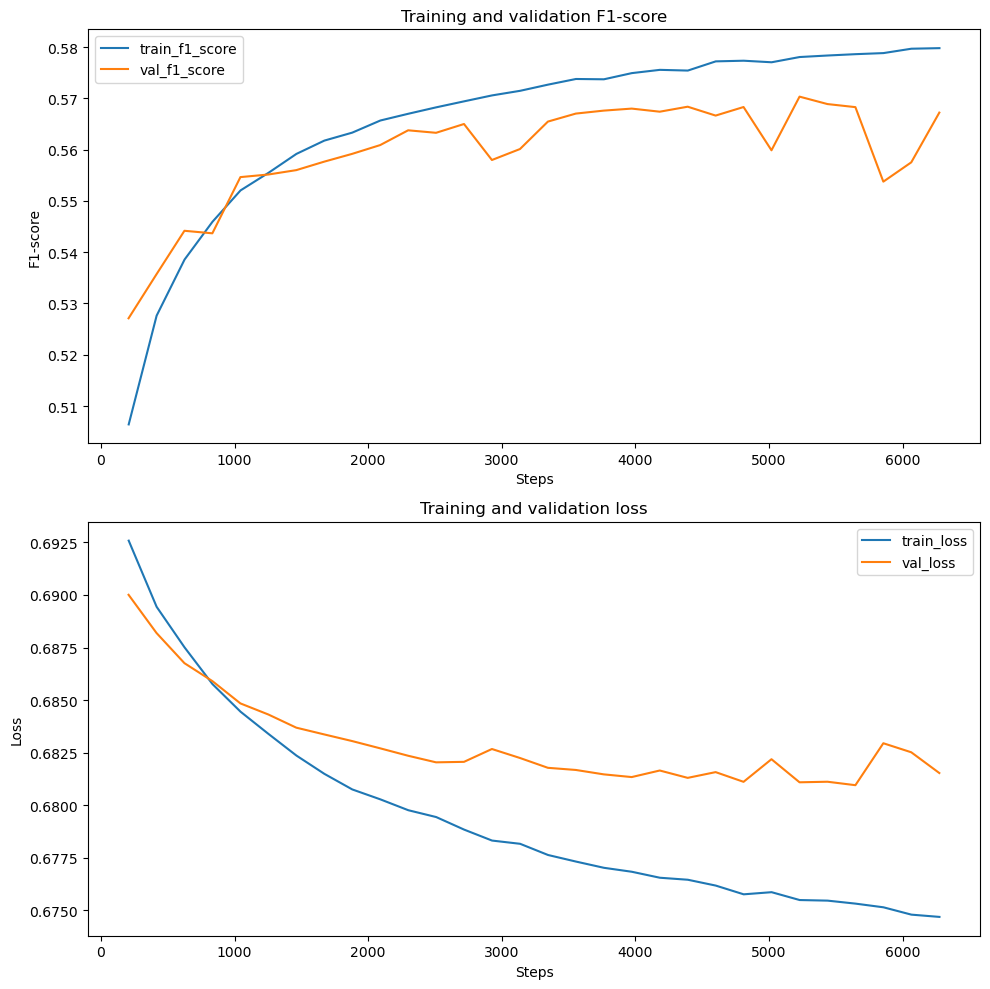

In [10]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_RP_pretext_task\version_2\metrics.csv')

In [11]:
# evaluate pretext model
evaluate_pretext_model(model, test_dataset, test_dataset.labels)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


OutOfMemoryError: CUDA out of memory. Tried to allocate 10.74 GiB. GPU 0 has a total capacity of 12.00 GiB of which 0 bytes is free. Of the allocated memory 11.65 GiB is allocated by PyTorch, and 477.10 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Soft Margin Loss

In [6]:
class PretextModel(pl.LightningModule):
    """
    Code taken and adjusted from pytorch implementation of EEGNet
    url: https://github.com/torcheeg/torcheeg/blob/v1.1.0/torcheeg/models/cnn/eegnet.py#L5
    """
    def __init__(self, num_extracted_features=100, dropout=0.25, weight_decay=0.00, learning_rate=0.001):
        super(PretextModel, self).__init__()
        self.weight_decay = weight_decay
        self.learning_rate = learning_rate
        # feature extractors
        self.EEGNet = EEGNet(num_extracted_features=num_extracted_features, dropout=dropout)
        
        # linear discriminate layer
        self.linear = nn.Linear(num_extracted_features, 1)

        # add metrics
        self.train_f1 = F1Score(task='multiclass', num_classes=2, average='macro')
        self.val_f1 = F1Score(task='multiclass', num_classes=2, average='macro')

    def forward(self, x1: torch.Tensor, x2) -> torch.Tensor:
        x1 = self.EEGNet(x1) # forward pass through EEGNet for first sample
        x2 = self.EEGNet(x2) # forward pass through EEGNet for second sample
        z = torch.abs(x1 - x2) # calculate the absolute difference between the two feature vectors (contrastive module)
        x = self.linear(z) # forward pass through linear layer
        return x
    
    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y = train_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('train_loss', loss, on_epoch=True, prog_bar=True)
        self.log('train_f1', self.train_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y = val_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('val_loss', loss, prog_bar=True, on_epoch=True)
        self.log('val_f1', self.val_f1(y_hat, y), prog_bar=True, on_epoch=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x = test_batch[0]
        y = test_batch[1]
        y = y
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        loss = F.soft_margin_loss(logits, y, reduce='sum')
        y = torch.where(y == -1, 0, y)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_f1', self.val_f1(y_hat, y), prog_bar=True)
        return loss
    
    def predict_step(self, batch):
        x = batch[0]
        x1 = x[:, 0, :, :].unsqueeze(1).float()
        x2 = x[:, 1, :, :].unsqueeze(1).float()
        logits = self.forward(x1, x2)
        logits = logits.view(-1)
        y_hat = F.sigmoid(logits)
        y_hat = torch.where(y_hat > 0.5, 1, 0)
        return y_hat
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, betas=(0.9, 0.999), weight_decay=self.weight_decay) # default hyperparameters (used in EEGNet paper)
        return optimizer
    


In [7]:
class Across_Subject_RPDataset(Dataset):
    def __init__(self, participant_ids, data_path, subsample=True, tpos=1, device='cpu', n_samples=2):
        """
        Dataset for the Relative Positioning task. Obtains n combinations of two epochs between all groups of two participants.
        :param participant_ids: List of participant IDs
        :param data_path: Path to the directory containing the preprocessed EEG data
        :param subsample: Whether to subsample the dataset for class balance or not
        :param tpos: Time/index difference of the epochs in which the epochs are considered adjacent
        :param device: Device to store the data ('cpu' or 'cuda')
        :param n_samples: Number of samples for each label (adjacent/separate) to generate for each participant combination
        """
        self.participant_ids = participant_ids
        self.data_path = data_path
        self.subsample = subsample
        self.tpos = tpos
        self.device = device
        self.n_samples = n_samples
        self.sampled_epochs_indices_id = []
        self.data_cache = {}
        self.labels = []
        self._load_data()

    def _load_data(self):
        epoch_data = {}
        for participant_id in self.participant_ids:
            # Load the data for the participant
            data = torch.load(os.path.join(self.data_path, f"{participant_id}.pt"))
            # Move data to the specified device
            data = torch.tensor(data)
            data = data.to(self.device)
            self.data_cache[participant_id] = data
        # Generate n combinations of two epochs between two participants
        self.sample_across_subject_combinations(self.data_cache, n=self.n_samples)
    
    def sample_across_subject_combinations(self, data_cache, n):
        all_participant_combinations = list(itertools.combinations(self.participant_ids, 2)) # all combinations of participants
        warning_displayed = False  # Flag to track if the warning has been displayed

        for participant_id_1, participant_id_2 in all_participant_combinations: 
            data_1 = self.data_cache[participant_id_1]
            data_2 = self.data_cache[participant_id_2]
            num_epochs_1 = data_1.shape[0]
            num_epochs_2 = data_2.shape[0]
            # Get all combinations of indices between data_1 and data_2
            all_combinations = list(itertools.product(range(num_epochs_1), range(num_epochs_2)))
            
            # Filter combinations based on the difference between indices
            adjacent_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) <= self.tpos and comb[0] != comb[1]]
            separate_combinations = [comb for comb in all_combinations if abs(comb[0] - comb[1]) > self.tpos]
            # Sample n combinations from each filtered set
            sampled_adjacent_combinations = random.sample(adjacent_combinations,
                                                        min(n, len(adjacent_combinations)))
            sampled_separate_combinations = random.sample(separate_combinations,
                                                     min(n, len(separate_combinations)))
            
            if n > len(adjacent_combinations) and not warning_displayed:
                print(f"Warning: asking for {n} adjacent samples, but only {len(adjacent_combinations)} adjacent samples available between two participants.")
                print("This will result in class imbalance.")
                warning_displayed = True  # Set the flag to True after displaying the warning

            # Store the combinations and labels
            for i, j in sampled_adjacent_combinations:
                self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, 1))
                self.labels.append(1)
            for i, j in sampled_separate_combinations:
                self.sampled_epochs_indices_id.append((participant_id_1, participant_id_2, i, j, -1))
                self.labels.append(0)

    def __len__(self):
        return len(self.sampled_epochs_indices_id)

    def __getitem__(self, idx):
        participant_id_1, participant_id_2, i, j, label = self.sampled_epochs_indices_id[idx]
        # Load the data for the participant on-the-fly
        data_1 = self.data_cache[participant_id_1]
        data_2 = self.data_cache[participant_id_2]
        epoch_1 = data_1[i]
        epoch_2 = data_2[j]
        sampled_epochs = torch.stack([epoch_1, epoch_2])
        # Convert to PyTorch tensor if it's a NumPy array
        if isinstance(sampled_epochs, np.ndarray):
            sampled_epochs = torch.tensor(sampled_epochs)
        # Transfer data to GPU in batches
        sampled_epochs = sampled_epochs.to('cuda')
        return sampled_epochs, label

#### Data loading & splitting

In [8]:
data_path = r"E:\TDBRAIN\thesis_epoched_data\EC"
participant_ids = get_participant_ids(data_path, epoch_dir=True)
# sample_ids = random.sample(participant_ids, 5)
# separate replication set here, because otherwise combinations between replication and training set would be possible
replication_ids = [par_id for par_id in participant_ids if par_id.startswith('sub-19')] 
training_ids = [par_id for par_id in participant_ids if not par_id.startswith('sub-19')]
test_dataset = Across_Subject_RPDataset(replication_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1)
train_dataset = Across_Subject_RPDataset(training_ids, data_path, subsample=True, device='cuda', tpos=1, n_samples=1)

print(np.unique(train_dataset.labels, return_counts=True))
print(len(train_dataset))
print(train_dataset[0][0].shape)

(array([0, 1]), array([646953, 646953], dtype=int64))
1293906
torch.Size([2, 26, 1244])


In [9]:
# split train into train/validation set

groups = [f"{pair[0]}_{pair[1]}" for pair in train_dataset.sampled_epochs_indices_id]
labels = train_dataset.labels


# Assuming trainval_indices is a list of indices for the train dataset
trainval_indices = list(range(len(labels)))

# Stratified group k-fold split
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=False)

# Split the train and validation set into train and validation set
for train_idx, val_idx in sgkf.split(trainval_indices, labels, groups):
    train_indices = [trainval_indices[i] for i in train_idx]
    val_indices = [trainval_indices[i] for i in val_idx]
    break  # We only need the first split

# Save indices to disk
np.save('data_train_indices.npy', train_indices)
np.save('data_val_indices.npy', val_indices)

In [10]:
# obtain actual train, val, test splits
# code from github copilot

# Load indices from disk
data_train_indices = np.load('data_train_indices.npy')
data_val_indices = np.load('data_val_indices.npy')

# Create subsets using the indices
data_train = Subset(train_dataset, data_train_indices)
data_val = Subset(train_dataset, data_val_indices)

# Print dataset sizes and label distributions
train_labels = [train_dataset.labels[i] for i in data_train_indices]
val_labels = [train_dataset.labels[i] for i in data_val_indices]

print(f"Train: {len(data_train)}, Val: {len(data_val)}, Test: {len(test_dataset)}")
print(f"Train: {np.unique(train_labels, return_counts=True)}")
print(f"Val: {np.unique(val_labels, return_counts=True)}")
print(f"Test: {np.unique(test_dataset.labels, return_counts=True)}")

Train: 1035124, Val: 258782, Test: 11130
Train: (array([0, 1]), array([517562, 517562], dtype=int64))
Val: (array([0, 1]), array([129391, 129391], dtype=int64))
Test: (array([0, 1]), array([5565, 5565], dtype=int64))


#### Training pretext model

In [11]:
model = train_pretext_model(
    pretext_task='acrossRP_soft_margin_loss_pretext_model',
    max_epochs=30,
    data_train=data_train,
    data_val=data_val,
    batch_size=1000,
    learning_rate=0.001,
    dropout=0.25,
    weight_decay=0,
    store_weights=(True, True)
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | EEGNet   | EEGNet            | 63.9 K
1 | linear   | Linear            | 101   
2 | train_f1 | MulticlassF1Score | 0     
3 | val_f1   | MulticlassF1Score | 0     
-----------------------------------------------
64.0 K    Trainable params
0         Non-trainable params
64.0 K    Total params
0.256     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


Best model checkpoint path: logs\across_RP_pretext_task\version_3\checkpoints\epoch=29-train_loss=0.68-train_f1=0.56-val_loss=0.69-val_f1=0.54.ckpt


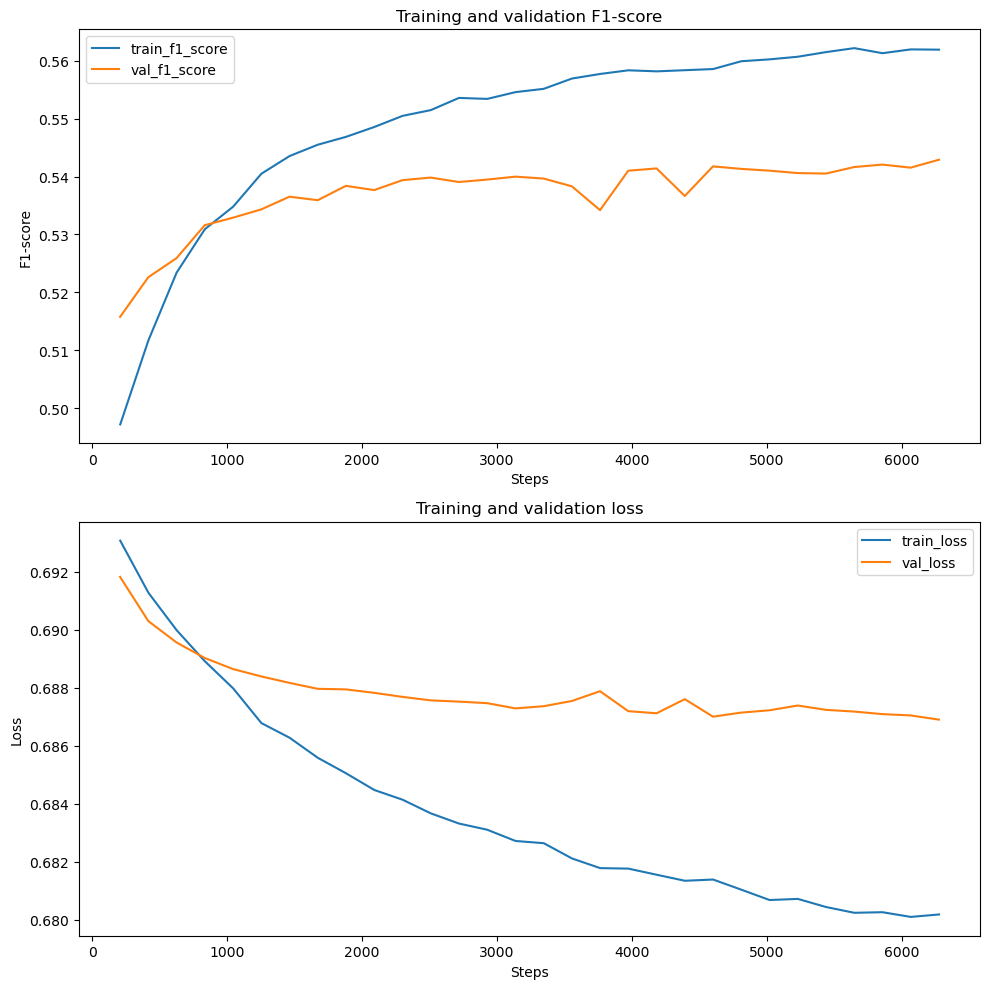

In [12]:
# plot training curves
plot_training_curves(r'D:\Documents\Master_Data_Science\Thesis\thesis_code\DataScience_Thesis\logs\across_RP_pretext_task\version_3\metrics.csv')

In [19]:
# evaluate pretext model
evaluate_pretext_model(model, data_test, test_labels)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          test_f1          │    0.5908399820327759     │
│         test_loss         │    0.6725582480430603     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


ValueError: Number of classes, 3, does not match size of target_names, 2. Try specifying the labels parameter